In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/poem-generation/poem.txt


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.utils as ku
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

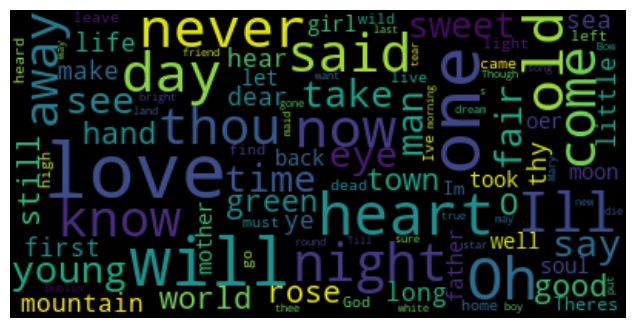

In [3]:
# Reading the text data file
data = open('/kaggle/input/poem-generation/poem.txt', encoding="utf8").read()

# EDA: Generating WordCloud to visualize
# the text
wordcloud = WordCloud(max_font_size=50,
					max_words=100,
					background_color="black").generate(data)

# Plotting the WordCloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("WordCloud.png")
plt.show()

In [4]:
type(data)

str

In [5]:
data

'Stay, I said\nto the cut flowers.\nThey bowed\ntheir heads lower.\nStay, I said to the spider,\nwho fled.\nStay, leaf.\nIt reddened,\nembarrassed for me and itself.\nStay, I said to my body.\nIt sat as a dog does,\nobedient for a moment,\nsoon starting to tremble.\nStay, to the earth\nof riverine valley meadows,\nof fossiled escarpments,\nof limestone and sandstone.\nIt looked back\nwith a changing expression, in silence.\nStay, I said to my loves.\nEach answered,\nAlways.\nTwo sets\nof family stories,\none long and detailed,\nabout many centuries\nof island ancestors, all living\non the same tropical farm...\nThe other side of the family tells stories\nthat are brief and vague, about violence\nin the Ukraine, which Dad\'s parents\nhad to flee forever, leaving all their\nloved ones\nbehind.\nThey don\'t even know if anyone\nsurvived.\nWhen Mami tells her flowery tales of Cuba,\nshe fills the twining words with relatives.\nBut when I ask my\nUkrainian-Jewish-American grandma\nabout her

In [6]:
# Generating the corpus by
# splitting the text into lines
corpus = data.lower().split("\n")
print(corpus[:10])

['stay, i said', 'to the cut flowers.', 'they bowed', 'their heads lower.', 'stay, i said to the spider,', 'who fled.', 'stay, leaf.', 'it reddened,', 'embarrassed for me and itself.', 'stay, i said to my body.']


In [7]:
# Fitting the Tokenizer on the Corpus
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

# Vocabulary count of the corpus
total_words = len(tokenizer.word_index)

print("Total Words:", total_words)


Total Words: 3807


In [14]:
# Converting the text into embeddings
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]

	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences,
										maxlen=max_sequence_len,
										padding='pre'))
predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
label = ku.to_categorical(label, num_classes=total_words+1)


In [15]:
input_sequences

array([[   0,    0,    0, ...,    0,  266,    3],
       [   0,    0,    0, ...,  266,    3,   59],
       [   0,    0,    0, ...,    0,    4,    1],
       ...,
       [   0,    0,    0, ..., 3807,   15,    4],
       [   0,    0,    0, ...,   15,    4,  203],
       [   0,    0,    0, ...,    4,  203,   85]], dtype=int32)

In [16]:
# predictors
input_sequences[:, :-1]

array([[   0,    0,    0, ...,    0,    0,  266],
       [   0,    0,    0, ...,    0,  266,    3],
       [   0,    0,    0, ...,    0,    0,    4],
       ...,
       [   0,    0,    0, ...,    8, 3807,   15],
       [   0,    0,    0, ..., 3807,   15,    4],
       [   0,    0,    0, ...,   15,    4,  203]], dtype=int32)

In [17]:
# label
input_sequences[:, -1]

array([  3,  59,   1, ...,   4, 203,  85], dtype=int32)

In [18]:
max_sequence_len

16

In [19]:
label

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [20]:
# Building a Bi-Directional LSTM Model
model = Sequential()
model.add(Embedding(total_words+1, 100,
					input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words+1/2, activation='relu',
				kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words+1, activation='softmax'))
model.compile(loss='categorical_crossentropy',
			optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 100)           380800    
                                                                 
 bidirectional (Bidirectiona  (None, 15, 300)          301200    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 3807)              384507    
                                                                 
 dense_1 (Dense)             (None, 3808)              14500864  
                                                        

In [21]:
history = model.fit(predictors, label, epochs=150, verbose=1)


Epoch 1/150
510/510 [==============================] - 25s 28ms/step - loss: 6.9527 - accuracy: 0.0616
Epoch 2/150
510/510 [==============================] - 7s 15ms/step - loss: 6.5191 - accuracy: 0.0636
Epoch 3/150
510/510 [==============================] - 7s 13ms/step - loss: 6.3378 - accuracy: 0.0646
Epoch 4/150
510/510 [==============================] - 7s 13ms/step - loss: 6.2266 - accuracy: 0.0707
Epoch 5/150
510/510 [==============================] - 6s 12ms/step - loss: 6.1358 - accuracy: 0.0766
Epoch 6/150
510/510 [==============================] - 6s 13ms/step - loss: 6.0556 - accuracy: 0.0824
Epoch 7/150
510/510 [==============================] - 6s 12ms/step - loss: 5.9477 - accuracy: 0.0912
Epoch 8/150
510/510 [==============================] - 6s 12ms/step - loss: 5.8314 - accuracy: 0.0998
Epoch 9/150
510/510 [==============================] - 7s 13ms/step - loss: 5.7256 - accuracy: 0.1047
Epoch 10/150
510/510 [==============================] - 6s 12ms/step - loss: 5.63

In [22]:
seed_text = "The world"
next_words = 25
ouptut_text = ""

for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences(
		[token_list], maxlen=max_sequence_len-1,
	padding='pre')
	predicted = np.argmax(model.predict(token_list,
										verbose=0), axis=-1)
	output_word = ""
	
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
			
	seed_text += " " + output_word
	
print(seed_text)

The world is muscle bound the world a wooden ball or a mossy shelter are not roads diverged in a cabin found for no cross all her


In [27]:
seed_text = "The world"
next_words = 25
ouptut_text = ""

for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences(
		[token_list], maxlen=max_sequence_len-1,
	padding='pre')
	predicted = np.argmax(model.predict(token_list,
										verbose=0), axis=-1)
	output_word = ""
	
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
			
	seed_text += " " + output_word
	
print(seed_text)

The world is muscle bound the world a wooden ball or a mossy shelter are not roads diverged in a cabin found for no cross all her


In [24]:
seed_text = "flower"
next_words = 25
ouptut_text = ""

for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences(
		[token_list], maxlen=max_sequence_len-1,
	padding='pre')
	predicted = np.argmax(model.predict(token_list,
										verbose=0), axis=-1)
	output_word = ""
	
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
			
	seed_text += " " + output_word
	
print(seed_text)

flower as our mother too ry suppose around me over you can be faithless scarce burn to play the trodden black thorn to banish all miles


In [28]:
seed_text = "flower"
next_words = 25
ouptut_text = ""

for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences(
		[token_list], maxlen=max_sequence_len-1,
	padding='pre')
	predicted = np.argmax(model.predict(token_list,
										verbose=0), axis=-1)
	output_word = ""
	
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
			
	seed_text += " " + output_word
	
print(seed_text)

flower as our mother too ry suppose around me over you can be faithless scarce burn to play the trodden black thorn to banish all miles


In [31]:
import pickle

# Save the tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save the model
model.save('model.h5')

# Save the history
with open('history.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

# ...........................

# # Load the tokenizer
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

# # Load the model
# model = load_model('model.h5')

# # Load the history
# with open('history.pickle', 'rb') as handle:
#     history = pickle.load(handle)

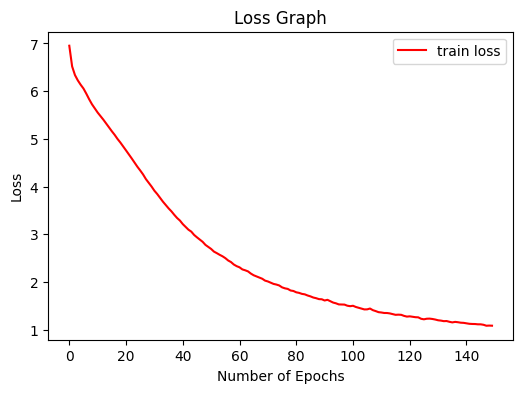

In [38]:
plt.figure(figsize=(6, 4))
plt.plot(history['loss'], 'r', label='train loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()


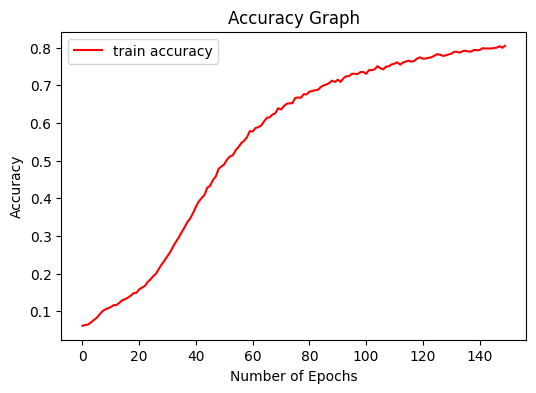

In [44]:
plt.figure(figsize=(6,4))
plt.plot(history['accuracy'],'r',label='train accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show()